# In this notebook, we develop the pipeline to perform evaluation on a trained ubteacher model

In [1]:
import os
import json
#import logging
import sys
from datetime import datetime
from pathlib import Path

# Hacky way to resolve project paths
sys.path.append(str(Path(os.getcwd()).parents[0]))
sys.path.append(str(Path(os.getcwd()).parents[1]))

import matplotlib.pyplot as plt
plt.rcParams.update({"font.size": 6})
#matplotlib.use('Agg')
import numpy as np
import torch

from detectron2.data import DatasetCatalog, MetadataCatalog
from detectron2.data import build_detection_test_loader
from detectron2.data import transforms as T
from detectron2.utils.visualizer import Visualizer
from detectron2.utils.logger import setup_logger
setup_logger()
from detectron2.config import get_cfg
from detectron2.engine import DefaultPredictor
from detectron2.evaluation import COCOEvaluator
from detectron2.structures import Boxes
from detectron2.data.datasets.coco import convert_to_coco_dict

from ubteacher.config import add_ubteacher_config
from ubteacher.modeling.meta_arch.rcnn import TwoStagePseudoLabGeneralizedRCNN
from ubteacher.engine.trainer import UBRCNNTeacherTrainer

#import ubteacher.utils.utils_v1 as utils_v1
import ubteacher.utils.ROI_utils as ROI_utils

In [2]:
print("Paths available in this notebook:")
for n, path in enumerate(sys.path):
    print(f"{n}. {path}")

Paths available in this notebook:
0. /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/notebooks
1. /home/jessechao/miniconda3/envs/AI_path/lib/python38.zip
2. /home/jessechao/miniconda3/envs/AI_path/lib/python3.8
3. /home/jessechao/miniconda3/envs/AI_path/lib/python3.8/lib-dynload
4. 
5. /home/jessechao/.local/lib/python3.8/site-packages
6. /home/jessechao/miniconda3/envs/AI_path/lib/python3.8/site-packages
7. /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2
8. /mnt/c/Users/jt_ch/SynologyDrive/project_goatface


## Recreate parts of classes and functions necessary for this notebook

In [3]:
def convert_to_coco_json(dataset_name: str, output_dir: str, allow_cached=True):
    """
    Converts dataset into COCO format and saves it to a json file.
    dataset_name must be registered in DatasetCatalog and in detectron2's standard format.

    Args:
    dataset_name -- reference from the config file to the catalogs
                    must be registered in DatasetCatalog and in detectron2's 
                    standard format
    output_file -- path of json file that will be saved to
    allow_cached -- if json file is already present then skip conversion
    """
    logger = setup_logger(name=__name__)
    coco_files = []
    for file in os.scandir(output_dir):
        if "coco" in file.name:
            coco_files.append(file.path)
    if coco_files:
        logger.info("Removing previously cached coco files...")
        for i in coco_files:
            logger.info(f"Removed {i}")
            os.remove(i)
    coco_dict = convert_to_coco_dict(dataset_name)
    coco_json = json.dumps(coco_dict, indent=4)
    coco_json_file = dataset_name + "_coco_format.json"
    print(os.path.join(output_dir, coco_json_file))
    
    with open(os.path.join(output_dir, coco_json_file), "w") as json_file:
        json_file.write(coco_json)

## Set validation data paths, load model

In [4]:
#model_path_parent = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/'
#model_path = os.path.join(model_path_parent, "model_0094999.pth")
#dataseed = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/dataseed/OSCC_TCGA_FullMix_1008.json'
#dataset_dir = '/mnt/voyage/Datasets_pathology/GT_2023/LesionFinder' #Temporarily voyage because GT is not sync'd to FN
#output_dir = '/home/chao_lab/SynologyDrive/chaolab_AI_path/unbiased_teacher2/output/test_eval'

dataseed = os.path.join(sys.path[7], "dataseed/OSCC_TCGA_FullMix_1008.json")
dataset_dir = "/mnt/d/SynologyDrive/GT_2023/LesionFinder"


In [5]:
# Load ledger from dataseed
with open(dataseed, 'r') as f:
    ledger = json.load(f)
    val_data = ledger['val']
sample_im_path = Path(val_data.get("images")[0])
source_dataset_dir = str(sample_im_path.parent.parent)
print(f"The data on this computer is in: {source_dataset_dir}")

# Adjust data paths for the current computer
for d in val_data:
    updated_paths = [
        i.replace(source_dataset_dir, dataset_dir) for i in val_data[d]
    ]
    val_data[d] = updated_paths
print("\nCheck a few files to see if their data paths are properly adjusted:")
for i in val_data["images"][:5]:
    print("    ", i)

The data on this computer is in: /home/chao_lab/GT_2023/LesionFinder

Check a few files to see if their data paths are properly adjusted:
     /mnt/d/SynologyDrive/GT_2023/LesionFinder/SRI_OSCC/Case 23 G5_1.npy
     /mnt/d/SynologyDrive/GT_2023/LesionFinder/SRI_OSCC/Case 16 J19_2.npy
     /mnt/d/SynologyDrive/GT_2023/LesionFinder/SRI_OSCC/Case 1 J10_1.npy
     /mnt/d/SynologyDrive/GT_2023/LesionFinder/SRI_OSCC/Case 4 F33_3.npy
     /mnt/d/SynologyDrive/GT_2023/LesionFinder/SRI_OSCC/Case 12 G4_0.npy


NOTE: Using register_dataset function (new) in ROI_utils
TODO: Move functions to utils_v1 under ubteacher module

In [6]:
# Dataset registration
reg_name = 'LesionFinder_val'
print(f"Registering {reg_name} to DatasetCatalog...")
# Fake a cat_map since its not currently used
cat_map = {'lesion': 0}
try:
    ROI_utils.TrainHelper().register_dataset(reg_name, val_data, cat_map)
    dataset_name = list(DatasetCatalog.items())[-1][0]
    print(f"The dataset {dataset_name} is now registered")
except:
    print(f"There was a problem with dataset registeration")
# Set prediction class name
ROI_metadata = MetadataCatalog.get(dataset_name).set(thing_classes=['lesion'])


Registering LesionFinder_val to DatasetCatalog...
working on 'ROI_LesionFinder_val'...
The dataset ROI_LesionFinder_val is now registered


In [7]:
model_path_parent = os.path.join(sys.path[7], "output")
#model_path = os.path.join(model_path_parent, "model_0094999.pth")
output_dir = os.path.join(model_path_parent, "test_eval")
# Set detection configs
print("\nSetting detection configs...")
print("Loading model...")
cfg = get_cfg()
add_ubteacher_config(cfg)
cfg.PARENTDIR = ""
cfg.DETECTION_MODE = ""
cfg.DATASEED = ""
cfg.MODEL.ROI_BOX_HEAD.BATCH_SIZE_PER_IMAGE = 10
cfg.MODEL.ROI_BOX_HEAD.NUM_CLASSES = 1
cfg.MODEL.RPN.NUM_CLASSES = 1
cfg.merge_from_file(os.path.join(model_path_parent, "config.yaml"))
cfg.MODEL.WEIGHTS = os.path.join(model_path_parent, "model_0094999.pth")
cfg.MODEL.ROI_HEADS.SCORE_THRESH_TEST = 0.5
cfg.DATASETS.TEST = dataset_name


Setting detection configs...
Loading model...


In [8]:
# Setup dataloader
dataloader = UBRCNNTeacherTrainer.build_test_loader(cfg, dataset_name)
# Initialize the model
model = DefaultPredictor(cfg).model
model.eval()
eval_dataset = cfg.DATASETS.TEST
thing_classes = ROI_metadata.thing_classes

[10/11 13:35:00 d2.data.build]: Distribution of instances among all 1 categories:
|  category  | #instances   |
|:----------:|:-------------|
|   lesion   | 56           |
|            |              |
[10/11 13:35:00 d2.data.common]: Serializing the dataset using: <class 'detectron2.data.common._TorchSerializedList'>
[10/11 13:35:00 d2.data.common]: Serializing 114 elements to byte tensors and concatenating them all ...
[10/11 13:35:00 d2.data.common]: Serialized dataset takes 0.10 MiB
[10/11 13:35:01 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/model_0094999.pth ...


Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up

In [9]:
# Prepare coco format json
convert_to_coco_json(eval_dataset, output_dir)

print("Begin evaluation using the COCO API...")
coco_evaluator = COCOEvaluator(
    dataset_name=eval_dataset,
    #tasks = ('bbox'),
    distributed=False,
    output_dir=output_dir,
    max_dets_per_image=10,
)

[10/11 13:35:07 __main__]: Removing previously cached coco files...
[10/11 13:35:07 __main__]: Removed /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/test_eval/coco_instances_results.json
[10/11 13:35:07 __main__]: Removed /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/test_eval/ROI_LesionFinder_val_coco_format.json
[10/11 13:35:07 __main__]: Removed /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/test_eval/ROI_LesionFinder_val_coco_format.json.lock
[10/11 13:35:07 d2.data.datasets.coco]: Converting dataset dicts into COCO format
[10/11 13:35:07 d2.data.datasets.coco]: Conversion finished, #images: 114, #annotations: 56
/mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/test_eval/ROI_LesionFinder_val_coco_format.json
Begin evaluation using the COCO API...
[10/11 13:35:07 d2.evaluation.coco_evaluation]: Trying to convert 'ROI_LesionFinder_val' to COCO format ...
WARNING [10/11 13:3

In [10]:
coco_evaluator.reset()

# Perform inference with stats
predictor = DefaultPredictor(cfg)

for inputs in dataloader:
    #test_img_id = inputs[0]['image_id']
    #print(test_img_id)
    #input_img = inputs[0]['image'].permute(1, 2, 0).numpy() # same as channel_last
    with torch.no_grad():
        preds = model(inputs)
    
    # Accumulate COCO evaluation metrics
    # NOTE If get numpy error, update pycocotools to 2.0.7
    coco_evaluator.process(inputs, preds)
    
coco_results = coco_evaluator.evaluate()

[10/11 13:35:11 d2.checkpoint.detection_checkpoint]: [DetectionCheckpointer] Loading from /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/model_0094999.pth ...


Some model parameters or buffers are not found in the checkpoint:
backbone.bottom_up.res2.0.conv1.norm.{bias, weight}
backbone.bottom_up.res2.0.conv1.weight
backbone.bottom_up.res2.0.conv2.norm.{bias, weight}
backbone.bottom_up.res2.0.conv2.weight
backbone.bottom_up.res2.0.conv3.norm.{bias, weight}
backbone.bottom_up.res2.0.conv3.weight
backbone.bottom_up.res2.0.shortcut.norm.{bias, weight}
backbone.bottom_up.res2.0.shortcut.weight
backbone.bottom_up.res2.1.conv1.norm.{bias, weight}
backbone.bottom_up.res2.1.conv1.weight
backbone.bottom_up.res2.1.conv2.norm.{bias, weight}
backbone.bottom_up.res2.1.conv2.weight
backbone.bottom_up.res2.1.conv3.norm.{bias, weight}
backbone.bottom_up.res2.1.conv3.weight
backbone.bottom_up.res2.2.conv1.norm.{bias, weight}
backbone.bottom_up.res2.2.conv1.weight
backbone.bottom_up.res2.2.conv2.norm.{bias, weight}
backbone.bottom_up.res2.2.conv2.weight
backbone.bottom_up.res2.2.conv3.norm.{bias, weight}
backbone.bottom_up.res2.2.conv3.weight
backbone.bottom_up

[10/11 13:35:30 d2.evaluation.coco_evaluation]: Preparing results for COCO format ...
[10/11 13:35:30 d2.evaluation.coco_evaluation]: Saving results to /mnt/c/Users/jt_ch/SynologyDrive/project_goatface/unbiased_teacher2/output/test_eval/coco_instances_results.json
[10/11 13:35:30 d2.evaluation.coco_evaluation]: Evaluating predictions with unofficial COCO API...
Loading and preparing results...
DONE (t=0.00s)
creating index...
index created!
Running per image evaluation...
Evaluate annotation type *bbox*
DONE (t=0.01s).
Accumulating evaluation results...
DONE (t=0.01s).
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=   all | maxDets= 10 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50      | area=   all | maxDets= 10 ] = 0.000
 Average Precision  (AP) @[ IoU=0.75      | area=   all | maxDets= 10 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area= small | maxDets= 10 ] = 0.000
 Average Precision  (AP) @[ IoU=0.50:0.95 | area=medium | maxDets= 10 ] = 0.000
 Average Precision  (AP)

Case 23 G5_1
(2569, 1822, 3)


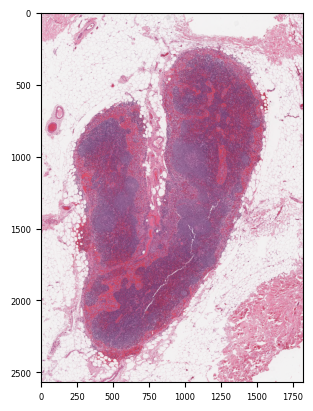

In [11]:
for inputs in dataloader:
    test_img_id = inputs[0]['image_id']
    print(test_img_id)
    img = (inputs[0]['image'].permute(1,2,0).numpy())
    print(np.shape(img))
    plt.imshow(img)
    plt.show(); plt.close()
    break

In [12]:
with torch.no_grad():
    outputs = model([inputs[0]])
instances = outputs[0]["instances"].to('cpu')
print(instances)

Instances(num_instances=13, image_height=2569, image_width=1822, fields=[pred_boxes: Boxes(tensor([[   0.0000,    0.0000, 1822.0000,   53.4198],
        [   0.0000, 1413.1896, 1822.0000, 1414.0963],
        [   0.0000, 1317.8749, 1822.0000, 1317.8766],
        [   0.0000,    0.0000, 1822.0000, 2569.0000],
        [   0.0000, 1264.4932, 1822.0000, 1264.5046],
        [ 147.0732, 1823.5857, 1822.0000, 2569.0000],
        [   0.0000, 1324.1864, 1822.0000, 1324.8348],
        [   0.0000, 1605.2742, 1822.0000, 1605.2754],
        [   0.0000, 1448.9792, 1822.0000, 1448.9812],
        [   0.0000, 1218.4003, 1822.0000, 1218.4020],
        [   0.0000,  326.7582, 1822.0000,  326.7610],
        [   0.0000,    0.0000, 1822.0000, 2569.0000],
        [   0.0000, 1468.9874, 1822.0000, 1468.9932]])), scores: tensor([1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000, 1.0000,
        1.0000, 1.0000, 1.0000, 0.9999]), pred_classes: tensor([1, 1, 1, 2, 1, 2, 1, 1, 1, 0, 1, 1, 1]), pred_boxes_